# How to use SDFC

## I. Preprocessing
### I.1 Packages

In [1]:
import sys,os
import pickle as pk
import itertools as itt

## Scientific libraries
##=====================
import numpy as np
import scipy.stats as sc

## Plot libraries
##===============
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### I.2 Custom classes

In [2]:
class Object(object):
	pass

### I.3 Custom functions

### I.5 Custom plot functions

In [3]:
def _figsize( nrow , ncol , npix = 5 , ratio = 13 / 9 ):
	return (ratio * ncol * npix , nrow * npix )

In [4]:
def _covariance_ellipse( PX , i = 0 , j = 1 , n_std = 3.0 , facecolor = "none" , **kwargs ):
	
	## Define the figure and axe
	if kwargs.get("ax") is not None:
		fig = kwargs.get("fig") ## Can be None
		ax  = kwargs.get("ax")
	else:
		if kwargs.get("fig") is not None:
			fig = kwargs.get("fig")
		else:
			fs = 1.3
			fig = plt.figure( figsize = (fs * 6,fs * 4) )
		ax = fig.add_subplot( 1 , 1 , 1 )
	
	if kwargs.get("ax") is not None:
		del kwargs["ax"]
	if kwargs.get("fig") is not None:
		del kwargs["fig"]
	
	
	if type(n_std) is not list:
		n_std = [n_std]
	
	if type(PX) == np.ndarray:
		PX = sc.multivariate_normal( mean = PX.mean(0) , cov = np.cov(PX.T) , allow_singular = True )
	
	pearson = PX.cov[i,j] / np.sqrt(PX.cov[i,i] * PX.cov[j,j])
	
	# Using a special case to obtain the eigenvalues of this
	# two-dimensionl dataset.
	ell_radius_x = np.sqrt(1 + pearson)
	ell_radius_y = np.sqrt(1 - pearson)
	scale_x = [np.sqrt(PX.cov[i,i]) * ns for ns in n_std]
	scale_y = [np.sqrt(PX.cov[j,j]) * ns for ns in n_std]

	for k,ns in enumerate(n_std):
		ellipse = mpl.patches.Ellipse( (0, 0) , width = ell_radius_x * 2 , height = ell_radius_y * 2 , facecolor=facecolor , **kwargs )
		
		transf = mpl.transforms.Affine2D() \
			.rotate_deg(45) \
			.scale(scale_x[k], scale_y[k]) \
			.translate(PX.mean[i],PX.mean[j])
		
		ellipse.set_transform(transf + ax.transData)
		ax.add_patch(ellipse)
	
	ax.relim()
	ax.autoscale_view()
	return fig,ax

In [5]:
def _violinplot( data , **kwargs ):
	
	## Define the figure and axe
	if kwargs.get("ax") is not None:
		fig = kwargs.get("fig") ## Can be None
		ax  = kwargs.get("ax")
	else:
		if kwargs.get("fig") is not None:
			fig = kwargs.get("fig")
		else:
			fs = 1.3
			fig = plt.figure( figsize = (fs * 6,fs * 4) )
		ax = fig.add_subplot( 1 , 1 , 1 )
	
	if kwargs.get("ax") is not None:
		del kwargs["ax"]
	if kwargs.get("fig") is not None:
		del kwargs["fig"]
	
	## Color
	color = "red"
	if kwargs.get("color") is not None:
		color = kwargs["color"]
	
	## Remove extrema
	if kwargs.get("showextrema") is None:
		kwargs["showextrema"] = False
	
	quantiles = kwargs.get("quantiles")
	if quantiles is not None:
		del kwargs["quantiles"]

	## Location
	positions = range(data.shape[1])
	if kwargs.get("positions") is None:
		kwargs["positions"] = positions
	else:
		positions = kwargs["positions"]
	
	## True plot
	l_vp = ax.violinplot( data , **kwargs )
	
	## Set color
	for vp in l_vp["bodies"]:
		vp.set_facecolor(color)
	
	ax.set_xticks(positions)
	
	## Add quantiles
	if quantiles is not None:
		delta = np.diff(positions).min() / 3
		for i,p in enumerate(positions):
			ax.hlines( np.quantile( data[:,i] , quantiles ) , p - delta , p + delta , color = color , alpha = 0.5 )
	
	return fig,ax

In [6]:
cplt = Object()
cplt.figsize  = _figsize
cplt.covariance_ellipse = _covariance_ellipse
cplt.violinplot = _violinplot

### I.6 Global parameters

In [7]:
darktheme_system = True
if darktheme_system:
	plt.style.use( "dark_background" )
	plt.rcParams["figure.facecolor"] = (0.1,0.1,0.1)
	plt.rcParams["axes.facecolor"] = (0.1,0.1,0.1)

In [8]:
glob = Object()
glob.n_samples = 2500

## II. Introduction

### II.1 Generalities on SDFC

### II.2 Architecture

### II.3 Import SDFC in python

The proposal syntax to import SDFC in python is

In [9]:
import SDFC as sd

### 1.4 Testing dataset
The function `sd.tools.Dataset.covariates` build three covariates and a time axis, usefull to be familiar with the SDFC syntax. The three covariates correspond to the three classical parameters of a distribution: the location, noted $\mu$, the scale, noted $\sigma$ and the shape, noted $\xi$. Three covariates noted $X_\mu$, $X_\sigma$ and $X_\xi$ are returned:

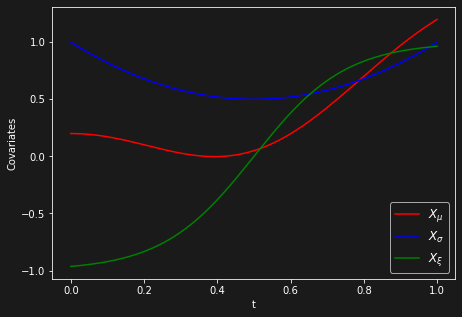

In [10]:
t,X_loc,X_scale,X_shape = sd.tools.Dataset.covariates(glob.n_samples)


fig = plt.figure( figsize = cplt.figsize(1,1) )
ax  = fig.add_subplot(1,1,1)
ax.plot( t , X_loc   , color = "red"   , linestyle = "-" , label = r"$X_\mu$" )
ax.plot( t , X_scale , color = "blue"  , linestyle = "-" , label = r"$X_\sigma$" )
ax.plot( t , X_shape , color = "green" , linestyle = "-" , label = r"$X_\xi$" )
ax.set_xlabel( "t" )
ax.set_ylabel( "Covariates" )
ax.legend( fontsize = 12 )
plt.show()

## III. Parametric Statistical laws

### III.1 Abstract Law : template of all laws

### III.2 Bootstrap and MLE, example with a Normal distribution

We start by define a dataset $Y$, from a Normal law $\mathcal{N}(\mu_t,\sigma_t)$, with:

$$
\begin{aligned}
\mu_t    &=    \mu_0 + \mu_1    X_\mu \\
\sigma_t &= \sigma_0 + \sigma_1 X_\sigma
\end{aligned}
$$

Our goal is to regress the parameters $\mu_0$, $\mu_1$, $\sigma_0$ and $\sigma_1$. Start by drawing realisations of the random variable $Y\sim\mathcal{N}(\mu_t,\sigma_t)$

In [11]:
loc   =  1 + 3 * X_loc
scale = -1 + 2 * X_scale
Y     = np.random.normal( loc = loc , scale = scale , size = glob.n_samples )

A fit using the maximum likelihood estimator is performed, with $100$ bootstrap. The keywords `c_loc` and `c_scale` define the two covariates of `loc` ($\mu$) and `scale` ($\sigma$) parameters. Print the law print a summary of coefficients fitted.

In [12]:
law_norm = sd.Normal( method = "mle" , n_bootstrap = 100 )
law_norm.fit( Y , c_loc = X_loc , c_scale = X_scale )
print(law_norm)

+--------------+--------+-----------+---------------+-----------------+-----------------+
| Normal (mle) |  Link  |   Type    |     coef      | Quantile 0.025  | Quantile 0.975  |
+==============+========+===========+===============+=================+=================+
| loc          | IdLink | Covariate | [1.0, 3.001]  | [0.999, 2.979]  | [1.009, 3.035]  |
+--------------+--------+-----------+---------------+-----------------+-----------------+
| scale        | IdLink | Covariate | [-0.98, 1.96] | [-1.056, 1.321] | [-0.544, 2.112] |
+--------------+--------+-----------+---------------+-----------------+-----------------+



We can see the quality of the fit with a visual check:

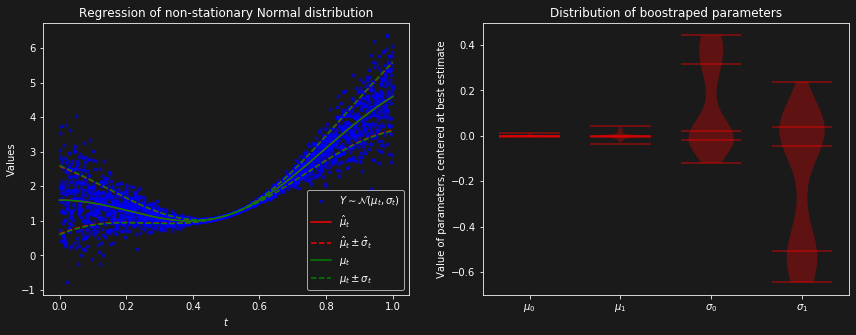

In [13]:
nrow,ncol = 1,2
fig = plt.figure( figsize = cplt.figsize(nrow,ncol) )

ax = fig.add_subplot( nrow , ncol , 1 )
ax.plot( t , Y , color = "blue" , linestyle = "" , marker = "." , alpha = 0.5 , label = r"$Y\sim\mathcal{N}(\mu_t,\sigma_t)$" )
ax.plot( t , law_norm.loc , color = "red" , linestyle = "-" , marker = "" , label = r"$\hat{\mu}_t$" )
ax.plot( t , law_norm.loc + law_norm.scale , color = "red" , linestyle = "--" , marker = "" , label = r"$\hat{\mu}_t\pm\hat{\sigma}_t$" )
ax.plot( t , law_norm.loc - law_norm.scale , color = "red" , linestyle = "--" , marker = "" )
ax.plot( t , loc , color = "green" , linestyle = "-" , marker = "" , label = r"$\mu_t$" )
ax.plot( t , loc + scale , color = "green" , linestyle = "--" , marker = "" , label = r"$\mu_t\pm\sigma_t$" )
ax.plot( t , loc - scale , color = "green" , linestyle = "--" , marker = "" )
ax.set_xlabel( r"$t$" )
ax.set_ylabel( "Values" )
ax.set_title( "Regression of non-stationary Normal distribution" )
ax.legend()

ax = fig.add_subplot( nrow , ncol , 2 )
cplt.violinplot( law_norm.coefs_bootstrap - law_norm.coef_ , ax = ax , quantiles = [0,0.25,0.5,0.75,1])
ax.set_xticklabels([r"$\mu_0$",r"$\mu_1$",r"$\sigma_0$",r"$\sigma_1$"])
ax.set_ylabel( "Value of parameters, centered at best estimate")
ax.set_title( "Distribution of boostraped parameters" )

plt.show()

If $\mu$ (or $\sigma$) are already known, you can pass it as fix parameter with the syntax `f_<param>`. If the `loc` is fixed:

In [14]:
law_norm_fl = sd.Normal() ## Fit with fix loc, default method is MLE
law_norm_fl.fit( Y , f_loc = loc , c_scale = X_scale )
print(law_norm_fl)

+--------------+--------+-----------+-----------------+
| Normal (mle) |  Link  |   Type    |      coef       |
+==============+========+===========+=================+
| loc          | IdLink | Fix       | None            |
+--------------+--------+-----------+-----------------+
| scale        | IdLink | Covariate | [-0.558, 1.458] |
+--------------+--------+-----------+-----------------+



and if the `scale` is fixed:

In [15]:
law_norm_fsc = sd.Normal() ## Fit with fix scale, default method is MLE
law_norm_fsc.fit( Y , c_loc = X_loc , f_scale = scale )
print(law_norm_fsc)

+--------------+--------+-----------+------------+
| Normal (mle) |  Link  |   Type    |    coef    |
+==============+========+===========+============+
| loc          | IdLink | Covariate | [1.0, 3.0] |
+--------------+--------+-----------+------------+
| scale        | IdLink | Fix       | None       |
+--------------+--------+-----------+------------+



Sometimes, it can be useful to pass a link function to a parameter. For example, to ensure the positivity of the scale we can assume that:
$\sigma_t = \exp(\sigma_0+\sigma_1 X_\sigma)$
It is easy with the generic keyword `l_<param>`.

In [16]:
law_norm_lf = sd.Normal() ## Default method is MLE
law_norm_lf.fit( Y , c_loc = X_loc , c_scale = X_scale , l_scale = sd.tools.ExpLink() )
print(law_norm_lf)

+--------------+--------------+-----------+-----------------+
| Normal (mle) |     Link     |   Type    |      coef       |
+==============+==============+===========+=================+
| loc          | IdLink       | Covariate | [1.003, 2.975]  |
+--------------+--------------+-----------+-----------------+
| scale        | ExpLink (>0) | Covariate | [-6.289, 7.227] |
+--------------+--------------+-----------+-----------------+



We can control with a graph the parameters fitted. Obviously, we have used an exponential link function whereas the $\sigma_t$ is linear, so the fit is slightly exponential:

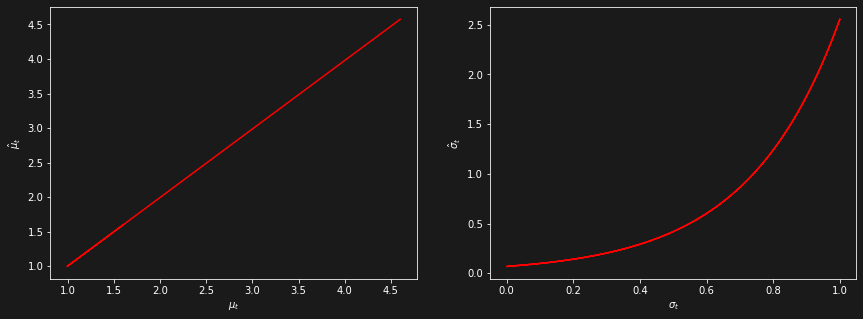

In [17]:
nrow,ncol = 1,2
fig = plt.figure( figsize = cplt.figsize(nrow,ncol) )

ax = fig.add_subplot( nrow , ncol , 1 )
ax.plot( loc , law_norm_lf.loc , color = "red" )
ax.set_xlabel( r"$\mu_t$" )
ax.set_ylabel( r"$\hat{\mu}_t$" )

ax = fig.add_subplot( nrow , ncol , 2 )
ax.plot( scale , law_norm_lf.scale , color = "red" )
ax.set_xlabel( r"$\sigma_t$" )
ax.set_ylabel( r"$\hat{\sigma}_t$" )

plt.show()

### III.3 Bayesian example with the GEV distribution

### III.2 Bootstrap and MLE, example with a Normal distribution

We start by define a dataset $Y$, from a Normal law $\mathcal{N}(\mu_t,\sigma_t)$, with:

$$
\begin{aligned}
\mu_t    &=    \mu_0 + \mu_1    X_\mu \\
\sigma_t &= \sigma_0 + \sigma_1 X_\sigma
\end{aligned}
$$

Our goal is to regress the parameters $\mu_0$, $\mu_1$, $\sigma_0$ and $\sigma_1$. Start by drawing realisations of the random variable $Y\sim\mathcal{N}(\mu_t,\sigma_t)$

In [18]:
loc   =  1 + 3   * X_loc
scale = -1 + 2   * X_scale
shape =  0 + 0.3 * X_shape
Y     = sc.genextreme.rvs( loc = loc , scale = scale , c = - shape , size = glob.n_samples )

A fit using the maximum likelihood estimator is performed, with $100$ bootstrap. The keywords `c_loc` and `c_scale` define the two covariates of `loc` ($\mu$) and `scale` ($\sigma$) parameters. Print the law print a summary of coefficients fitted.

In [43]:
law_gev = sd.GEV( method = "bayesian" )
prior = sc.multivariate_normal( mean = [1,3,-1,2,0,0.3] , cov = 0.1 * np.identity(6) )
law_gev.fit( Y , c_loc = X_loc , c_scale = X_scale , c_shape = X_shape , n_mcmc_drawn = 20000 , prior = prior )
print(law_gev)

/usr/local/lib/python3.7/site-packages/SDFC-0.5.0b6-py3.7-macosx-10.15-x86_64.egg/SDFC/__AbstractLaw.py:438: RuntimeWarning: invalid value encountered in double_scalars
  p_accept = np.exp( p_next - p_current )
/usr/local/lib/python3.7/site-packages/SDFC-0.5.0b6-py3.7-macosx-10.15-x86_64.egg/SDFC/__AbstractLaw.py:438: RuntimeWarning: overflow encountered in exp
  p_accept = np.exp( p_next - p_current )


+----------------+--------+-----------+-----------------+
| GEV (bayesian) |  Link  |   Type    |      coef       |
+================+========+===========+=================+
| loc            | IdLink | Covariate | [0.992, 3.08]   |
+----------------+--------+-----------+-----------------+
| scale          | IdLink | Covariate | [-0.942, 1.875] |
+----------------+--------+-----------+-----------------+
| shape          | IdLink | Covariate | [-0.09, 0.227]  |
+----------------+--------+-----------+-----------------+



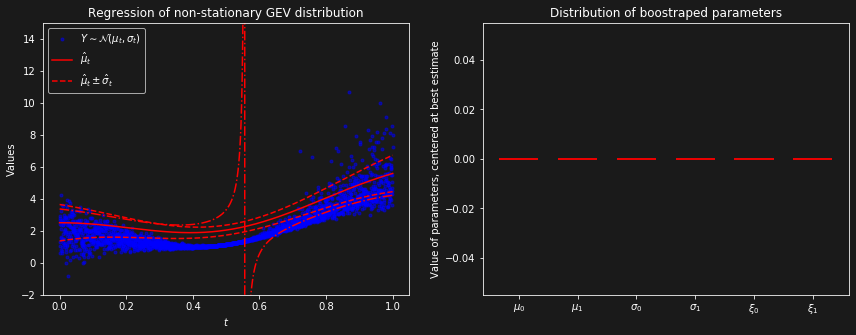

In [41]:
nrow,ncol = 1,2
fig = plt.figure( figsize = cplt.figsize(nrow,ncol) )

ax = fig.add_subplot( nrow , ncol , 1 )
ax.plot( t , Y , color = "blue" , linestyle = "" , marker = "." , alpha = 0.5 , label = r"$Y\sim\mathcal{N}(\mu_t,\sigma_t)$" )
ax.plot( t , law_gev.loc , color = "red" , linestyle = "-" , marker = "" , label = r"$\hat{\mu}_t$" )
ax.plot( t , law_gev.loc + law_gev.scale , color = "red" , linestyle = "--" , marker = "" , label = r"$\hat{\mu}_t\pm\hat{\sigma}_t$" )
ax.plot( t , law_gev.loc - law_gev.scale , color = "red" , linestyle = "--" , marker = "" )
ylim = ax.get_ylim()
ax.plot( t , law_gev.loc - law_gev.scale / law_gev.shape , color = "red" , linestyle = "-." , marker = "" )
ylim = [-2,15]
ax.set_ylim(ylim)
ax.set_xlabel( r"$t$" )
ax.set_ylabel( "Values" )
ax.set_title( "Regression of non-stationary GEV distribution" )
ax.legend()

ax = fig.add_subplot( nrow , ncol , 2 )
cplt.violinplot( law_gev.info.draw[10000:,:] - np.median( law_gev.info.draw[10000:,:] ,axis = 0 ) , ax = ax , quantiles = [0,0.25,0.5,0.75,1])
ax.set_xticklabels([r"$\mu_0$",r"$\mu_1$",r"$\sigma_0$",r"$\sigma_1$",r"$\xi_0$",r"$\xi_1$"])
ax.set_ylabel( "Value of parameters, centered at best estimate")
ax.set_title( "Distribution of boostraped parameters" )

plt.show()

## IV. Non Parametric Statistics

### IV.1 Classic statistics (mean, variance, etc)

### IV.2 Quantile Regression

## V. Useful tools

### V.1 Link Function

### V.2 Plot confidence interval of parameters